In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import random 

In [3]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    db_data = []
    db_cols = ['premise', 'hypothesis', 'label', 'predicted_scores', 'predicted_label']
    for d in data:
        db_data.append([])
        for col in db_cols:
            db_data[-1].append(d.get(col, float('nan')))
    return pd.DataFrame(db_data, columns=db_cols)

# Evaluation on original set

In [83]:
df_og = load_jsonl('eval_results/original_predictions.jsonl')
print("Example premise: ", df_og.loc[1][0])
print("Example hypothesis: ", df_og.loc[1][1])

Loaded 9842 records from eval_results/original_predictions.jsonl
Example premise:  Two women are embracing while holding to go packages.
Example hypothesis:  Two woman are holding packages.


In [13]:
print("Accuracy: ", "%.3f" % (1 - len(df_og.loc[df_og['label']!=df_og['predicted_label']])/len(df_og)))

Accuracy:  0.896


Text(0.5, 1.0, 'Distribution of predicted labels')

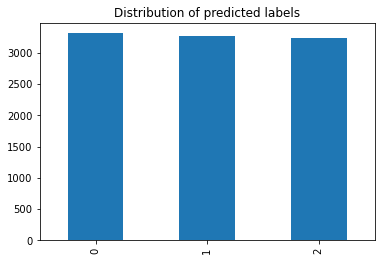

In [20]:
df_og['predicted_label'].value_counts().plot(kind='bar')
plt.title("Distribution of predicted labels")

# Evaluation on set with repeated hypotheses

In [82]:
df_rp = load_jsonl('eval_results/repeat_predictions.jsonl')
print("Example premise: ", df_rp.loc[1][0])
print("Example hypothesis: ", df_rp.loc[1][1])

Loaded 9842 records from eval_results/repeat_predictions.jsonl
Example premise:  Two women are embracing while holding to go packages.
Example hypothesis:  Two woman are holding packages. Two woman are holding packages.


In [22]:
print("Accuracy: ", "%.3f" % (1 - len(df_rp.loc[df_rp['label']!=df_rp['predicted_label']])/len(df_rp)))

Accuracy:  0.496


This is assuming true labels do not change when hypotheses are repeated.

Text(0.5, 1.0, 'Distribution of predicted labels')

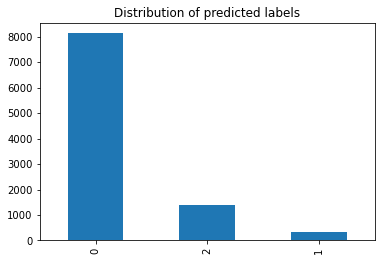

In [23]:
df_rp['predicted_label'].value_counts().plot(kind='bar')
plt.title("Distribution of predicted labels")

In [85]:
cont_to_ent = df_rp.index[(df_og['label']==2) & (df_og['predicted_label']==2) & (df_rp['predicted_label']==0)]
len(cont_to_ent)

1690

1690 examples were correctly predicted as contradictions in the original dataset but were predicted as entailments in the repeated dataset. 

In [88]:
ex = cont_to_ent[random.randrange(len(cont_to_ent))]
print("Premise: ", df_og.loc[ex][0])
print()
print("Original hypothesis: ", df_og.loc[ex][1])
print("Predicted label: ", df_og.loc[ex][4])
print()
print("Repeated hypothesis: ", df_rp.loc[ex][1])
print("Predicted label: ", df_rp.loc[ex][4])

Premise:  A man waving at the camera holding a stick with a pile of wood.

Original hypothesis:  The man hit the camera.
Predicted label:  2

Repeated hypothesis:  The man hit the camera. The man hit the camera.
Predicted label:  0
